In [93]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [94]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

Station = Base.classes.stations
Measurement = Base.classes.measurements

session = Session(bind=engine)

In [95]:
#Precipitation Analysis
year_ago = datetime.strptime('2017-01-01', '%Y-%m-%d')
vacation_start_date = datetime.strptime('2018-02-10', '%Y-%m-%d')
vacation_end_date = datetime.strptime('2018-02-20', '%Y-%m-%d')

prcp_data = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all())


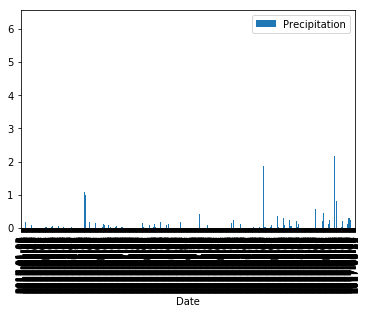

In [96]:
df = pd.DataFrame(prcp_data, columns=['date', 'prcp'])
precipitation_df = df.rename(columns={"date":"Date","prcp":"Precipitation"})
precipitation_df.set_index('Date', inplace=True, )
plt.figure();
precipitation_df.plot(kind='bar');
plt.show()

In [97]:
#  summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,1391.000000
mean,0.150884
std,0.435784
min,0.000000
25%,0.000000
50%,0.000000
75%,0.090000
max,6.250000


In [98]:
#Station analysis
#Design a query to calculate the total number of stations.
station_results = (session.query(Station.station).count())
station_results

9

In [99]:
#Design a query to find the most active stations
query_2 = (session
          .query(Station.station.label('station'), func.count(Measurement.date).label('Observations'))
          .filter(Station.station == Measurement.station)
          .group_by(Station.station)
          .order_by(func.count(Measurement.date).desc()).all())
#List the stations and observation counts in descending order
query_2

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [100]:
#Which station has the highest number of observations
highest_no_of_obs = query_2[0][0]
highest_no_of_obs

'USC00519281'

In [101]:
query_3 = (session
          .query(Measurement.tobs.label("Temprature"))
          .filter(Measurement.date >= year_ago)
          .filter(Measurement.station == highest_no_of_obs)
          .all())
query_3

[(70),
 (64),
 (63),
 (63),
 (62),
 (70),
 (70),
 (62),
 (62),
 (63),
 (65),
 (69),
 (77),
 (70),
 (74),
 (69),
 (72),
 (71),
 (69),
 (71),
 (71),
 (72),
 (72),
 (69),
 (70),
 (66),
 (65),
 (69),
 (68),
 (68),
 (68),
 (59),
 (60),
 (70),
 (73),
 (75),
 (64),
 (59),
 (59),
 (62),
 (68),
 (70),
 (73),
 (79),
 (75),
 (65),
 (70),
 (74),
 (70),
 (70),
 (71),
 (71),
 (71),
 (69),
 (61),
 (67),
 (65),
 (72),
 (71),
 (73),
 (72),
 (77),
 (73),
 (67),
 (62),
 (64),
 (67),
 (66),
 (81),
 (69),
 (66),
 (67),
 (69),
 (66),
 (68),
 (65),
 (74),
 (69),
 (72),
 (73),
 (72),
 (71),
 (76),
 (77),
 (76),
 (74),
 (68),
 (73),
 (71),
 (74),
 (75),
 (70),
 (67),
 (71),
 (67),
 (74),
 (77),
 (78),
 (67),
 (70),
 (69),
 (69),
 (74),
 (78),
 (71),
 (67),
 (68),
 (67),
 (76),
 (69),
 (72),
 (76),
 (68),
 (72),
 (74),
 (70),
 (67),
 (72),
 (60),
 (65),
 (75),
 (70),
 (75),
 (70),
 (79),
 (75),
 (70),
 (67),
 (74),
 (70),
 (75),
 (76),
 (77),
 (74),
 (74),
 (74),
 (69),
 (68),
 (76),
 (74),
 (71),
 (71),
 (74),

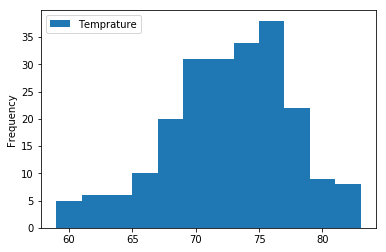

In [102]:
temprature_df = pd.DataFrame(query_3, columns=['Temprature'])
plt.figure()
temprature_df.plot.hist(bins=12)
plt.show()

In [103]:
def calc_temp(start_date, end_date):
    query = (session
            .query(func.min(Measurement.tobs).label("Minimum Temp"), func.max(Measurement.tobs).label("Maximum Temp"), func.avg(Measurement.tobs).label("Average Temp"))
            .filter(Measurement.date >= start_date)
            .filter(Measurement.date <= end_date)
            .all())
    return query
prev_year_start_date = (vacation_start_date - relativedelta(years=1)).strftime('%Y-%m-%d')
prev_year_end_date = (vacation_end_date - relativedelta(years=1)).strftime('%Y-%m-%d')
result = calc_temp(prev_year_start_date,  prev_year_end_date)

In [104]:
result

[(62, 80, 71.40298507462687)]

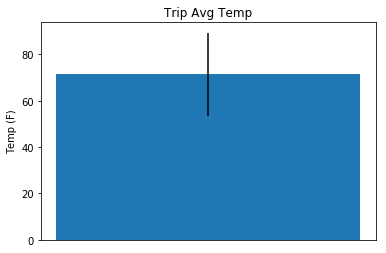

In [105]:
fig1, ax1 = plt.subplots()
# Create the boxplot
Avg = [result[0][2]]
Min = result[0][0]
Max = result[0][1]
x = range(1)
rects = ax1.bar( x, Avg, yerr=Max-Min)
ax1.xaxis.set_ticks_position('none') 
ax1.set_ylabel('Temp (F)')
ax1.set_title('Trip Avg Temp')
ax1.xaxis.set_visible(False)
plt.show()

In [107]:
# import Flask
from flask import Flask, jsonify
import json

# define app
app = Flask("Climate App")


#Add routes
@app.route("/api/v1.0/precipitation")
def get_precipitation_data():
    query_result = (session
            .query(Measurement.date, Measurement.tobs)
            .filter(Measurement.date >= year_ago)
            .all())
    prcp_dict = {}
    for row in query_result:
        prcp_dict[row[0]] = row[1]
    return jsonify(prcp_dict)

@app.route("/api/v1.0/stations")
def get_stations():
    query_result = (session
            .query(Station.station, Station.name)
            .all())
    json_list = []
    d = {}
    for row in query_result:
        d['station code']=row[0]
        d['station name']=row[1]
        json_list.append(d)
    return json.dumps(json_list, separators=(',',':'))

@app.route("/api/v1.0/tobs")
def get_prev_year_temps():
    query_result = (session
            .query(Measurement.tobs, Measurement.date, Measurement.station)
            .filter(Measurement.date >= year_ago)
            .all())
    json_list = []
    d = {}
    for row in query_result:
        d['station code']=row[2]
        d['date']=row[1].strftime('%Y-%m-%d')
        d['temp']=row[0]
        json_list.append(d)
    return json.dumps(json_list, separators=(',',':'))

@app.route("/api/v1.0/<start>")
@app.route("/api/v1.0/<start>/<end>")
def get_temprature_min_max_avg(start, end="2017-31-12"):
    start_date =  datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    result = calc_temp(start_date, end_date)
    mydict = {}
    mydict['Minimum Temp'] = result[0][0]
    mydict['Maximum Temp'] = result[0][1]
    mydict['Average Temp'] = result[0][2]
    return jsonify(mydict)
    
